In [168]:
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import os
import time
import copy
import random

from torchvision import utils
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torchvision.transforms as transform
from torch import Tensor
from torchsummary import summary
from torch import optim

from einops import rearrange,reduce,repeat
from einops.layers.torch import Rearrange, Reduce

In [169]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [170]:
# specify path to data
path2data = './dataset'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))
     

Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [171]:
# define transformation
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(224)
])

# apply transformation to dataset
train_ds.transform = transformation
val_ds.transform = transformation

# make dataloade
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True)

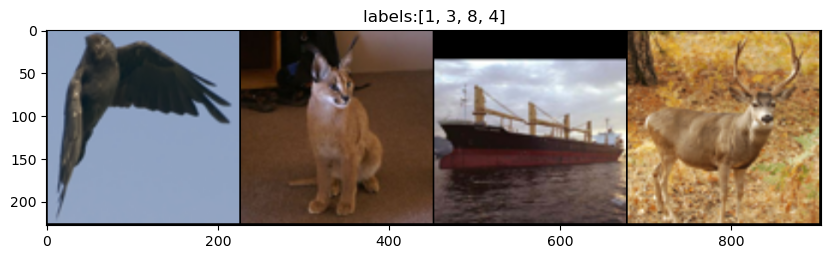

In [172]:
# check sample images
def show(img, y=None):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(10)
torch.manual_seed(0)

grid_size=4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [train_ds[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

In [173]:
img = next(iter(train_dl))[0][0]
x = img.unsqueeze(0).to(device)
x.shape

torch.Size([1, 3, 224, 224])

![img](./images/VIT.png)

In [174]:
class patchembedding(nn.Module):
    def __init__(self, in_features = 3, batch_size=32, patch_size=16, emb_size=768):
        super().__init__()
        self.b = batch_size
        self.p = patch_size
        self.c = in_features
        self.projection = nn.Linear(self.p*self.p*self.c, emb_size)
        

    def forward(self,x):
        b,c,h,w = x.shape
        x = x.view(b, (h//self.p)*(w//self.p), (self.p*self.p*c))
        x = self.projection(x)
        return x

In [176]:
patchembedding().to(device)(x).shape

torch.Size([1, 196, 768])

- 논문의 내용상 Linear을 쓰는게 맞지만, 저자의 코드에서 projection 과정을 Convnet을 이용하였음
- 그 이유는 Convnet을 활용하는 것이 성능적으로 더 우수했다고 설명함

In [159]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_features = 3, patch_size=16, emb_size=768):
        super().__init__()
        self.p = patch_size
        self.c = in_features
        self.e = emb_size
        self.projection = nn.Conv2d(self.c,self.e,kernel_size = self.p, stride=self.p) #stride=patch_size여야 patch 단위별로 image가 나눠져서 embedding됨

    def forward(self,x):
        b,c,h,w = x.shape
        x = self.projection(x)
        x = x.view(b, (h//self.p)*(w//self.p), (self.p*self.p*c)) #(batchsize,patch_num,embedding_size)
        cls_tokens = nn.Parameter(torch.rand(b,1,self.e)).to(device) #cls token
        x = torch.cat([cls_tokens,x],dim=1)
        pos_emb = nn.Parameter(torch.rand(b, (h//self.p)*(w//self.p)+1, (self.p*self.p*c))).to(device) #pos emb
        x = x+pos_emb

        return x

In [177]:
patchembedding().to(device)(x).shape

torch.Size([1, 196, 768])

In [161]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int=768, head_num: int=8, dropout: float=0):
        super().__init__()
        self.emb_size = emb_size
        self.head_num = head_num
        #self.qkv = nn.Linear(emb_size,emb_size*3)
        self.query = nn.Linear(emb_size,emb_size)
        self.key = nn.Linear(emb_size,emb_size)
        self.value = nn.Linear(emb_size,emb_size)
        self.scaling = (self.emb_size//self.head_num)**-0.5
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size,emb_size)

    def forward(self,x: Tensor, mask: Tensor=None) :
        #q,k,v를 linear projection 한 뒤 multi-head만큼 병렬적으로 나눠줌
        queries = rearrange(self.query(x),'b n (h d) -> b h n d', h = self.head_num)
        keys = rearrange(self.key(x),'b n (h d) -> b h n d', h = self.head_num)
        values = rearrange(self.value(x),'b n (h d) -> b h n d', h = self.head_num)
        
        #scaled dot-product attention
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries,keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.masked_fill(~mask, fill_value)
        att = F.softmax(energy*self.scaling,dim=-1)
        att = self.att_drop(att)

        out = torch.einsum('bhal, bhlv -> bhav', att, values)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)
        return out

In [178]:
patches_embedded = PatchEmbedding().to(device)(x)
MultiHeadAttention().to(device)(patches_embedded).shape

torch.Size([1, 197, 768])

In [179]:
class ResidualAdd(nn.Module):
    def __init__(self,fn):
        super().__init__()
        self.fn = fn

    def forward(self,x, **kwargs):
        res = x
        x = self.fn(x,**kwargs)
        x += res
        return x

In [180]:
class FeedForwardBlock(nn.Module):
    def __init__(self,emb_size :int, expansion: int=4, drop_p: float=0):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(emb_size,emb_size*expansion),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(emb_size*expansion,emb_size)
        )

    def forward(self,x):
        return self.network(x)
        

In [181]:
class Transformer_Encoder_Block(nn.Module):
    def __init__(self,emb_size: int=768, drop_p: float=0, forward_expansion: int=4, forward_dropout: float=0, **kwargs):
        super().__init__()
        self.encoder = nn.Sequential(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size,**kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size,expansion=forward_expansion,drop_p=forward_dropout),
                nn.Dropout(drop_p)
            ))
        )
    def forward(self,x):
        return self.encoder(x)
        

In [182]:
patches_embedded = PatchEmbedding().to(device)(x)
Transformer_Encoder_Block().to(device)(patches_embedded).shape

torch.Size([1, 197, 768])

In [183]:
class Transformer_Encoder(nn.Sequential):
    def __init__(self,depth: int=12, **kwargs):
        super().__init__(*[Transformer_Encoder_Block(**kwargs) for _ in range(depth)])

In [184]:
class Classification(nn.Module):
    def __init__(self,emb_size,n_class):
        super().__init__()
        self.cls = nn.Sequential(
            Reduce('b n e -> b e', reduction = 'mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_class)
        )
    def forward(self,x):
        return self.cls(x)

In [185]:
class ViT(nn.Sequential):
    def __init__(self, 
                in_channels: int=3,
                patch_size: int=16,
                emb_size: int=768,
                depth=12,
                 n_classes: int=10,
                 **kwargs
                ):
        super().__init__(
            PatchEmbedding(in_channels,patch_size,emb_size),
            Transformer_Encoder(depth,**kwargs),
            Classification(emb_size,n_classes)
        )

In [192]:
summary(ViT().to(device), (3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
    PatchEmbedding-2             [-1, 197, 768]               0
         LayerNorm-3             [-1, 197, 768]           1,536
            Linear-4             [-1, 197, 768]         590,592
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
           Dropout-7          [-1, 8, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
MultiHeadAttention-9             [-1, 197, 768]               0
          Dropout-10             [-1, 197, 768]               0
      ResidualAdd-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

# Train

In [166]:
model = ViT().to(device)

In [153]:
# define the loss function, optimizer and lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [154]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [155]:

# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric
     

In [156]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        loop = tqdm(loader, leave=True)
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history
     

In [157]:
# define the training parameters
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')
     


In [167]:
# Start training
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/9, current lr= 0.01
Copied best model weights!
train loss: 2.392650, val loss: 2.390371, accuracy: 10.53, time: 1.5909 min
----------
Epoch 1/9, current lr= 0.01
Copied best model weights!
train loss: 2.388488, val loss: 2.389723, accuracy: 10.46, time: 3.1617 min
----------
Epoch 2/9, current lr= 0.01
Copied best model weights!
train loss: 2.395295, val loss: 2.388948, accuracy: 11.15, time: 4.7148 min
----------
Epoch 3/9, current lr= 0.01
Copied best model weights!
train loss: 2.387881, val loss: 2.388906, accuracy: 10.96, time: 6.2752 min
----------
Epoch 4/9, current lr= 0.01
train loss: 2.391182, val loss: 2.392600, accuracy: 10.89, time: 7.8525 min
----------
Epoch 5/9, current lr= 0.01
Copied best model weights!
train loss: 2.390313, val loss: 2.387700, accuracy: 11.33, time: 9.4311 min
----------
Epoch 6/9, current lr= 0.01
train loss: 2.389002, val loss: 2.391178, accuracy: 10.85, time: 10.9881 min
----------
Epoch 7/9, current lr= 0.01
train loss: 2.387996, val loss: